In [2]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np

import seaborn as sns
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import pingouin as pg
import scikit_posthocs as sp

import sys
sys.path.append("../")
from DataSorting import *
from Averaging import *
from DWI import *
import numpy as np
import matplotlib.pyplot as plt

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
# helper function for image edge outline 
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img ==0] = 'nan'
    edges_img[edges_img >0] = 1
    return edges_img

In [4]:
# Pick volunteer, vv=0 0 was used to make the figure in the manuscript, this corresponds to volunteer 1 
vv = 1

In [5]:
volunteers=[1,2,3,4,5,7,8,9,10,11]


# For each volunteer 
M0_mag = np.zeros((128,128,6,4,5,8))
M1_mag = np.zeros((128,128,6,4,5,8))
M2_mag = np.zeros((128,128,6,4,5,8))

M0_phs = np.zeros((128,128,6,4,5,8))
M1_phs = np.zeros((128,128,6,4,5,8))
M2_phs = np.zeros((128,128,6,4,5,8))


volunteer = str(volunteers[vv])
print(volunteer, end = ' ')
inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
name = inpath.split('/')
namejoin = '/'.join(name[:-1])

num = 0
for num in range(3):
    nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
    bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
    bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
    mask_files   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
    

    nii_files.sort()
    bval_files.sort()
    bvec_files.sort()
    mask_files.sort()
    
    data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
    bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
    bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
    mask,header =  nrrd.read(os.path.join(inpath, mask_files[num]))
    
    mask = mask.astype('float')
    mask[mask==0] = np.nan
    
    
    data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)
    
    ims = np.stack((data1[:,:,:,:,:5],data1[:,:,:,:,5:10],data1[:,:,:,:,10:15],
                        data1[:,:,:,:,15:20],data1[:,:,:,:,20:25],data1[:,:,:,:,25:30],
                        data1[:,:,:,:,30:35],data1[:,:,:,:,35:40]),axis = -1)  
        
    
    mag = abs(ims)
    phs = np.angle(ims)
    mask_rep = np.tile(mask[:,:,:,np.newaxis,np.newaxis,np.newaxis],(1,1,1,ims.shape[3],ims.shape[4],ims.shape[5]))
    mask_rep[mask_rep ==0] = np.nan
    
    if num == 0:
        M0_mag[:,:,:,:,:,:] = mag #* mask_rep
        M0_phs[:,:,:,:,:,:,] = phs #*mask_rep
        M0_mask = mask_rep #*mask_rep
        
    if num == 1:
        M1_mag[:,:,:,:,:,:,] = mag #* mask_rep
        M1_phs[:,:,:,:,:,:] = phs #*mask_rep
        M1_mask = mask_rep #*mask_rep
        
    if num == 2:
        M2_mag[:,:,:,:,:,:] = mag #* mask_rep
        M2_phs[:,:,:,:,:,:] = phs #*mask_rep
        M2_mask = mask_rep #*mask_rep

# One data structure of complex dataset 
im_M0 = M0_mag * np.exp(1j*M0_phs)
im_M1 = M1_mag * np.exp(1j*M1_phs)
im_M2 = M2_mag * np.exp(1j*M2_phs)

2 

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
averaged_M0 = np.zeros((128,128,6,4,8),dtype = 'complex128')
averaged_M1 = np.zeros((128,128,6,4,8),dtype = 'complex128')
averaged_M2 = np.zeros((128,128,6,4,8),dtype = 'complex128')

adc_M0 = np.zeros((128,128,6,8))
adc_M1 = np.zeros((128,128,6,8))
adc_M2 = np.zeros((128,128,6,8))


for ii in range(8):
    [avg,_,_ ]= average(im_M0[:,:,:,:,:,ii],[],[],operation_type='Complex')
    averaged_M0[:,:,:,:,ii] = np.squeeze(avg)
    adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
    adc_M0[:,:,:,ii] = adc[0]['ADC']

    [avg,_,_ ]= average(im_M1[:,:,:,:,:,ii],[],[],operation_type='Complex')
    averaged_M1[:,:,:,:,ii] = np.squeeze(avg)

    adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
    adc_M1[:,:,:,ii] = adc[0]['ADC']

    [avg,_,_ ]= average(im_M2[:,:,:,:,:,ii],[],[],operation_type='Complex')
    averaged_M2[:,:,:,:,ii] = np.squeeze(avg)

    adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
    adc_M2[:,:,:,ii] = adc[0]['ADC']


../DWI.py:45: RuntimeWarning: divide by zero encountered in log
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
../DWI.py:45: RuntimeWarning: invalid value encountered in log
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
../DWI.py:46: RuntimeWarning: divide by zero encountered in log
  D_yy                             = -(1 / b) * np.log(S_y / S_0)                                                             # Calculate y diffusion coefficient
../DWI.py:46: RuntimeWarning: invalid value encountered in log
  D_yy                             = -(1 / b) * np.log(S_y / S_0)                                                             # Calculate y diffusion coefficient
../DWI.py:47: RuntimeWarning: divide by zero encountered in log
  D_zz                            

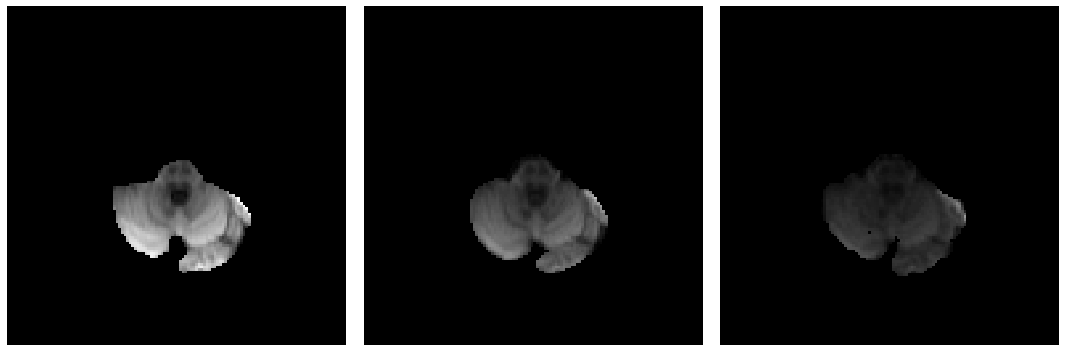

In [13]:
td = 5
sl = 1
diff = 3


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ii in range(3):
    axes[ii].imshow(np.zeros((128,128)),cmap = 'gray',vmax = 500,vmin = 0)
    axes[ii].axis('off')


axes[0].imshow(np.real(averaged_M0)[:,:,sl,diff,td]*M0_mask[:,:,sl,diff,0,td],vmin = 0,vmax = 500,cmap = 'gray',interpolation = 'nearest')
axes[1].imshow(np.real(averaged_M1)[:,:,sl,diff,td]*M1_mask[:,:,sl,diff,0,td],vmin = 0,vmax = 500,cmap = 'gray',interpolation = 'nearest')
axes[2].imshow(np.real(averaged_M2)[:,:,sl,diff,td]*M2_mask[:,:,sl,diff,0,td],vmin = 0,vmax = 500,cmap = 'gray',interpolation = 'nearest')

plt.tight_layout()

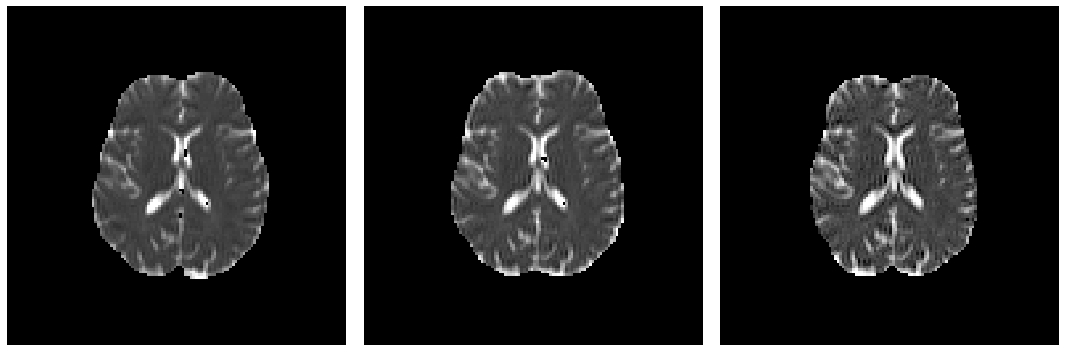

In [17]:
td = 1
sl = 3
diff = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ii in range(3):
    axes[ii].imshow(np.zeros((128,128)),cmap = 'gray',vmax = 500,vmin = 0)
    axes[ii].axis('off')


axes[0].imshow(np.real(adc_M0)[:,:,sl,td]*M0_mask[:,:,sl,diff,0,td],vmin = 0,vmax = 3,cmap = 'gray',interpolation = 'nearest')
axes[1].imshow(np.real(adc_M1)[:,:,sl,td]*M1_mask[:,:,sl,diff,0,td],vmin = 0,vmax = 3,cmap = 'gray',interpolation = 'nearest')
axes[2].imshow(np.real(adc_M2)[:,:,sl,td]*M2_mask[:,:,sl,diff,0,td],vmin = 0,vmax = 3,cmap = 'gray',interpolation = 'nearest')

plt.tight_layout()

In [ ]:
# whole brain histogram, regress plot magnitude vs. complex averaging for the given sample , pixel pool all volunteers for single slice see agreement between magnitude and complex averaging also could do bland altman about the bias difference between 2 approaches 